## Dropout and DeCov analysis

In [3]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob, os, copy, yaml, pprint
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, DATA_PATH_FLOWERS_PETS, SERVER_PROJECT_PATH

In [4]:
CHECKPOINT_PATHS = {
    'resnet50': {}
}
for k in CHECKPOINT_PATHS.keys():
    for config in glob.glob(f'configs/{k}_*.yaml'):
        with open(config) as fp:
            metadata = yaml.safe_load(fp)
        CHECKPOINT_PATHS[k][metadata['append_path']] = metadata['checkpoint_path']
pprint.pprint(CHECKPOINT_PATHS, indent=1)

{'resnet50': {'decov_0.0001': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet/resnet50_bs_256_seed_420_lr_0.01_opt_sgd_step_500.0_warmup_1000_gradclip_1.0_decov_0.0001/epoch=48-topk=1.ckpt',
              'drop_rate_0.1': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet/resnet50drop_rate_0.1_bs_256_seed_420_lr_0.01_opt_sgd_step_500.0_warmup_1000_gradclip_1.0/epoch=84-topk=1.ckpt',
              'drop_rate_0.2': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet/resnet50drop_rate_0.2_bs_256_seed_420_lr_0.01_opt_sgd_step_500.0_warmup_1000_gradclip_1.0/epoch=48-topk=1.ckpt',
              'drop_rate_0.3': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet/resnet50drop_rate_0.3_bs_256_seed_420_lr_0.01_opt_sgd_step_500.0_warmup_1000_gradclip_1.0/epoch=48-topk=1.ckpt',
              'drop_rate_0.4': '/NS/robustness_2/work/vnanda/inva

In [5]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [6]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else \
            DATA_PATH_FLOWERS_PETS if finetuning_dataset in ['flowers','oxford-iiit-pets'] else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False})
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        FINETUNE_MODE, fraction, seed)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    gt, pred = out[2], out[0]
    return accuracy(gt, pred)

In [7]:
def results(model, source_dataset, analysis_type='drop_rate', finetune_bs=None, FRACTIONS_OR_NUMBERS=None):
    assert analysis_type == 'drop_rate' or analysis_type == 'decov'
    plt_str = '== Finetuning results ==\n\n'
    model_to_frac_wise_test = {}
    finetune_bs = FINETUNE_BS if finetune_bs is None else finetune_bs
    for append in CHECKPOINT_PATHS[model].keys():
        print (append, analysis_type)
        if analysis_type not in append:
            continue
        plt_str += f'=== {model} - {append} ===\n\n'
        for ft_ds in FINETUNING_DATASETS:
            plt_str += f'==== {ft_ds} ====\n\n'
            frac_wise_val_accs, frac_wise_test_accs = {}, {}
            if FRACTIONS_OR_NUMBERS is None:
                FRACTIONS_OR_NUMBERS = sorted(
                    list(set(
                        [float(x.split('/frac-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                  f'{source_dataset}-ft-{ft_ds}/'
                                  f'*-bs-{finetune_bs}-{append}') \
                         if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                            'full-feature' not in x and \
                            'layer' not in x and \
                            'pool' not in x]
                        )))
            for frac in FRACTIONS_OR_NUMBERS:
                if isinstance(frac, int):
                    actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
                else:
                    actual_fraction = frac
                PARTIAL_CHOICE_SEEDS = sorted(
                    list(set(
                        [int(x.split('-seed-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'frac-{actual_fraction:.5f}-*-bs-{finetune_bs}-{append}') \
                        if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                           'full-feature' not in x and \
                           'layer' not in x and \
                           'pool' not in x]
                        )))
                for seed in PARTIAL_CHOICE_SEEDS:
                    model_path = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                           f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-{seed}-'
                                           f'ftmode-linear-lr-*-bs*-{append}/'
                                           '*-topk=1.ckpt') \
                                  if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                     'full-feature' not in x and \
                                     'layer' not in x and \
                                     'pool' not in x]
                    if len(model_path) == 0:
                        continue
                    model_path = model_path[0]
                    
                    pickled_preds = load_predictions(model_path)
                    if pickled_preds is not None:
                        test_acc = accuracy(pickled_preds['gt'], pickled_preds['pred']).item()
                    else:
                        test_acc = get_test_acc(model, source_dataset, ft_ds, 
                                                CHECKPOINT_PATHS[model][append], 
                                                model_path, seed, actual_fraction)
                    sd = torch.load(model_path)
                    val_acc = list(sd['callbacks'].values())[0]['best_model_score'].item()
                    if frac in frac_wise_val_accs:
                        frac_wise_val_accs[frac].append(val_acc)
                        frac_wise_test_accs[frac].append(test_acc)
                    else:
                        frac_wise_val_accs[frac] = [val_acc]
                        frac_wise_test_accs[frac] = [test_acc]
            
            model_to_frac_wise_test[f'{model}-{append}-{ft_ds}'] = copy.deepcopy(frac_wise_test_accs)
            
            full_acc_val = frac_wise_val_accs.pop(FRACTIONS_OR_NUMBERS[-1])
            full_acc_test = frac_wise_test_accs.pop(FRACTIONS_OR_NUMBERS[-1])
            x_vals, y_vals = list(zip(*sorted(frac_wise_val_accs.items(), key=lambda t: t[0])))
            _, y_tests = list(zip(*sorted(frac_wise_test_accs.items(), key=lambda t: t[0])))
            
            print (model, append, ft_ds)
            print (f'Full Acc: {full_acc_test}')
            for x, y in zip(x_vals, y_tests):
                print (f'For {x}, acc: {np.nanmean(y)} +/- {np.nanstd(y)}')
            print ()
            
            plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
                [[np.mean(_y) for _y in y_vals], [np.mean(_y) for _y in y_tests]], 
                'Fraction/number of neurons', 'Transfer Accuracy', ft_ds, 
                subfolder=source_dataset, filename=f'{model}_{ft_ds}_bs_{finetune_bs}_{append}_{FINETUNE_MODE}', 
                extension='png', x_vals=x_vals, 
                legend_vals=['Val', 'Test', 'Full Layer (Val)', 'Full Layer (Test)'], 
                vertical_line=None, horizontal_lines=[np.mean(full_acc_val), np.mean(full_acc_test)], 
                horizontal_lines_err=[np.std(full_acc_val), np.std(full_acc_test)], 
                colors=[plt_hp.COLORS[0], plt_hp.COLORS[1], plt_hp.COLORS[0], plt_hp.COLORS[1]], 
                linestyles=['-', '-', ':', ':'], y_lims=(0.,1.), root_dir='.', 
                paper_friendly_plots=False, plot_inside=False, legend_location='best', 
                savefig=True, figsize=(10,6), marker=[True, True, False, False], 
                results_subfolder_name='decorrelation_analysis', grid_spacing=None, 
                y_err=[[np.std(_y) for _y in y_vals], [np.std(_y) for _y in y_tests]], 
                legend_ncol=None), SERVER_PROJECT_PATH, size=700))
            print (ft_ds, frac_wise_val_accs)
    with open(f'./results/decorrelation_analysis/{source_dataset}/'
              f'wiki_results-{model}-{FINETUNE_MODE}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 
                                          'decorrelation_analysis', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return model_to_frac_wise_test

In [8]:
def estimate_dr(fractions, corresponding_accs, delta):
    '''
    fractions: a list of fractions (will be sorted)
    corresponding_accs: a list of lists where each list contains accuracy along multiple random seeds
    delta: what fraction of full layer accuracy do you want from the fraction
    '''
    fractions, corresponding_accs = list(zip(*sorted(zip(fractions, corresponding_accs), 
                                                     key=lambda x: x[0])))
    full_acc = np.mean(corresponding_accs[-1])
    ratios = np.array([])
    for fr, accs in zip(fractions, corresponding_accs):
        ratios = np.append(ratios, np.mean(accs) / full_acc)
    return 1 - fractions[np.argmin(np.abs(ratios - delta))]

drop_rate_0.3 drop_rate
resnet50 drop_rate_0.3 cifar10
Full Acc: [0.7350000143051147]
For 0.0005, acc: 0.12530000507831573 +/- 0.0
For 0.001, acc: 0.1543000042438507 +/- 0.0
For 0.005, acc: 0.26030001044273376 +/- 0.0
For 0.01, acc: 0.3695000112056732 +/- 0.0
For 0.05, acc: 0.6008999943733215 +/- 0.0
For 0.1, acc: 0.6565999984741211 +/- 0.0
For 0.2, acc: 0.6830999851226807 +/- 0.0
For 0.5, acc: 0.7161999940872192 +/- 0.0
For 0.8, acc: 0.7290999889373779 +/- 0.0



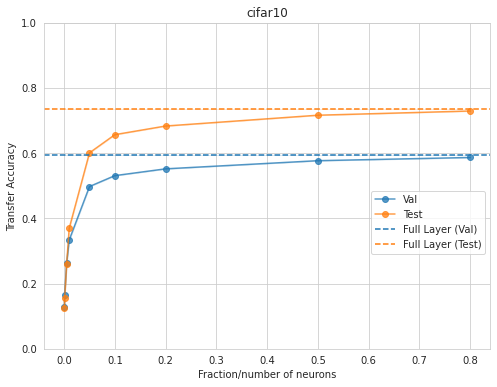

cifar10 {0.0005: [0.12680000066757202], 0.001: [0.16459999978542328], 0.005: [0.2639999985694885], 0.01: [0.3335999846458435], 0.05: [0.4976000189781189], 0.1: [0.531000018119812], 0.2: [0.551800012588501], 0.5: [0.5767999887466431], 0.8: [0.5866000056266785]}
resnet50 drop_rate_0.3 cifar100
Full Acc: [0.4065999984741211]
For 0.0005, acc: 0.009999999776482582 +/- 0.0
For 0.001, acc: 0.010300000198185444 +/- 0.0
For 0.005, acc: 0.03009999915957451 +/- 0.0
For 0.01, acc: 0.04100000113248825 +/- 0.0
For 0.05, acc: 0.15189999341964722 +/- 0.0
For 0.1, acc: 0.26660001277923584 +/- 0.0
For 0.2, acc: 0.3102000057697296 +/- 0.0
For 0.5, acc: 0.3684000074863434 +/- 0.0
For 0.8, acc: 0.39329999685287476 +/- 0.0



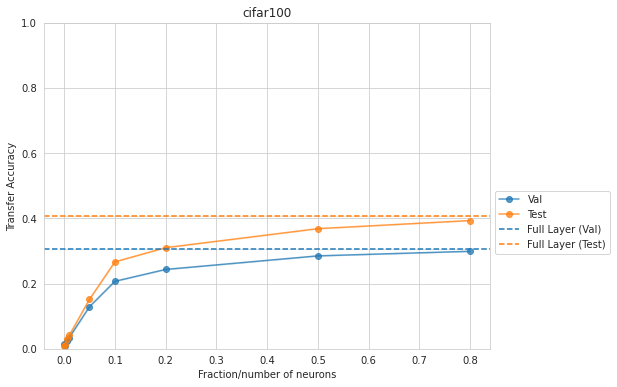

cifar100 {0.0005: [0.013799999840557575], 0.001: [0.009600000455975533], 0.005: [0.023400001227855682], 0.01: [0.03420000150799751], 0.05: [0.12919999659061432], 0.1: [0.2070000022649765], 0.2: [0.24340000748634338], 0.5: [0.2849999964237213], 0.8: [0.2990000247955322]}
resnet50 drop_rate_0.3 flowers
Full Acc: [0.14425109326839447]
For 0.0005, acc: 0.004878842271864414 +/- 0.0
For 0.001, acc: 0.004065701737999916 +/- 0.0
For 0.005, acc: 0.018702227622270584 +/- 0.0
For 0.01, acc: 0.006505122873932123 +/- 0.0
For 0.05, acc: 0.00943242758512497 +/- 0.0
For 0.1, acc: 0.011709220707416534 +/- 0.0
For 0.2, acc: 0.0419580414891243 +/- 0.0
For 0.5, acc: 0.05919661745429039 +/- 0.0
For 0.8, acc: 0.08960806578397751 +/- 0.0



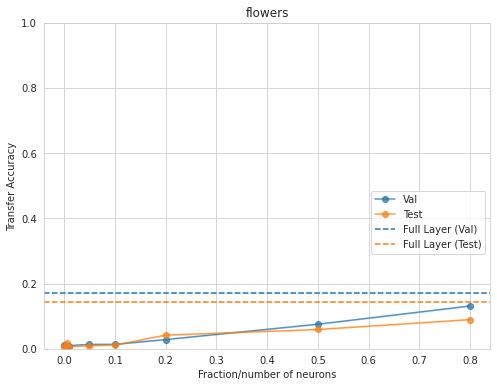

flowers {0.0005: [0.010784314014017582], 0.001: [0.0049019609577953815], 0.005: [0.009803921915590763], 0.01: [0.009803921915590763], 0.05: [0.013725491240620613], 0.1: [0.013725491240620613], 0.2: [0.028431372717022896], 0.5: [0.07549019902944565], 0.8: [0.13137255609035492]}
resnet50 drop_rate_0.3 oxford-iiit-pets
Full Acc: [0.8296538591384888]
For 0.0005, acc: 0.029163260012865067 +/- 0.0
For 0.001, acc: 0.027255382388830185 +/- 0.0
For 0.005, acc: 0.04306350648403168 +/- 0.0
For 0.01, acc: 0.0585990734398365 +/- 0.0
For 0.05, acc: 0.2504769563674927 +/- 0.0
For 0.1, acc: 0.43008995056152344 +/- 0.0
For 0.2, acc: 0.6718451976776123 +/- 0.0
For 0.5, acc: 0.8070318698883057 +/- 0.0
For 0.8, acc: 0.8214772343635559 +/- 0.0



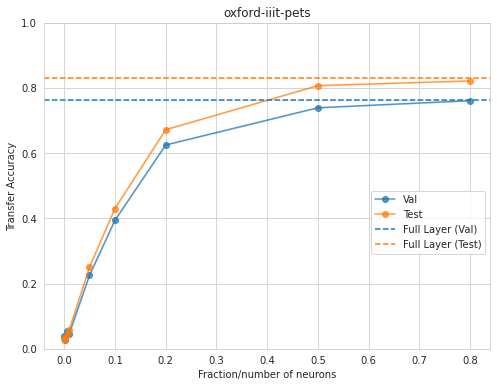

oxford-iiit-pets {0.0005: [0.03804347664117813], 0.001: [0.02717391401529312], 0.005: [0.054347824305295944], 0.01: [0.04619564861059189], 0.05: [0.22554348409175873], 0.1: [0.39402174949645996], 0.2: [0.625], 0.5: [0.739130437374115], 0.8: [0.760869562625885]}
drop_rate_0.7 drop_rate
resnet50 drop_rate_0.7 cifar10
Full Acc: [0.7034000158309937]
For 0.0005, acc: 0.10790000110864639 +/- 0.0
For 0.001, acc: 0.15129999816417694 +/- 0.0
For 0.005, acc: 0.2378000020980835 +/- 0.0
For 0.01, acc: 0.36649999022483826 +/- 0.0
For 0.05, acc: 0.5626999735832214 +/- 0.0
For 0.1, acc: 0.6161999702453613 +/- 0.0
For 0.2, acc: 0.6459000110626221 +/- 0.0
For 0.5, acc: 0.6818000078201294 +/- 0.0
For 0.8, acc: 0.695900022983551 +/- 0.0



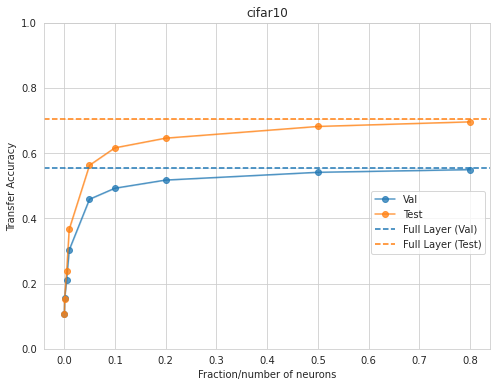

cifar10 {0.0005: [0.10740000009536743], 0.001: [0.15439999103546143], 0.005: [0.2120000123977661], 0.01: [0.30300000309944153], 0.05: [0.4585999846458435], 0.1: [0.49239999055862427], 0.2: [0.5174000263214111], 0.5: [0.5412000417709351], 0.8: [0.5493999719619751]}
resnet50 drop_rate_0.7 cifar100
Full Acc: [0.3772999942302704]
For 0.0005, acc: 0.009800000116229057 +/- 0.0
For 0.001, acc: 0.011599999852478504 +/- 0.0
For 0.005, acc: 0.022099999710917473 +/- 0.0
For 0.01, acc: 0.030400000512599945 +/- 0.0
For 0.05, acc: 0.15459999442100525 +/- 0.0
For 0.1, acc: 0.2312999963760376 +/- 0.0
For 0.2, acc: 0.27649998664855957 +/- 0.0
For 0.5, acc: 0.3346000015735626 +/- 0.0
For 0.8, acc: 0.3621000051498413 +/- 0.0



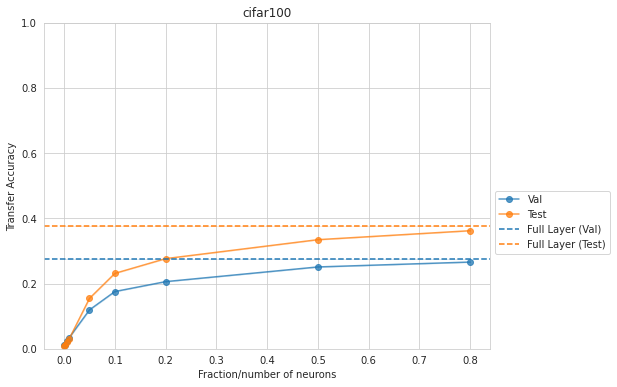

cifar100 {0.0005: [0.01119999960064888], 0.001: [0.011599999852478504], 0.005: [0.02539999969303608], 0.01: [0.03420000150799751], 0.05: [0.11939999461174011], 0.1: [0.17559999227523804], 0.2: [0.20600000023841858], 0.5: [0.25099998712539673], 0.8: [0.26600000262260437]}
resnet50 drop_rate_0.7 flowers
Full Acc: [0.06570173799991608]
For 0.0005, acc: 0.004065701737999916 +/- 0.0
For 0.001, acc: 0.006342494860291481 +/- 0.0
For 0.005, acc: 0.016262806951999664 +/- 0.0
For 0.01, acc: 0.007318262942135334 +/- 0.0
For 0.05, acc: 0.013660757802426815 +/- 0.0
For 0.1, acc: 0.01886485517024994 +/- 0.0
For 0.2, acc: 0.015287038870155811 +/- 0.0
For 0.5, acc: 0.05285412445664406 +/- 0.0
For 0.8, acc: 0.05626931041479111 +/- 0.0



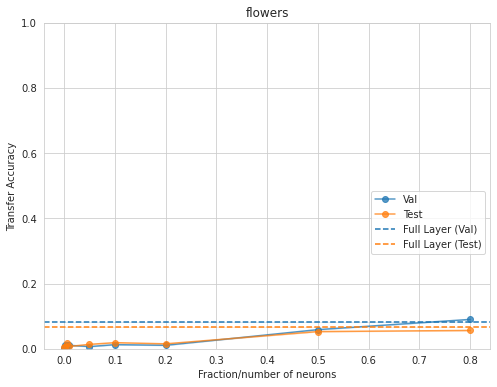

flowers {0.0005: [0.002941176760941744], 0.001: [0.010784314014017582], 0.005: [0.01274509821087122], 0.01: [0.010784314014017582], 0.05: [0.006862745154649019], 0.1: [0.012745099142193794], 0.2: [0.010784314014017582], 0.5: [0.05882352963089943], 0.8: [0.09019608050584793]}
resnet50 drop_rate_0.7 oxford-iiit-pets
Full Acc: [0.8296538591384888]
For 0.0005, acc: 0.039247751235961914 +/- 0.0
For 0.001, acc: 0.026982828974723816 +/- 0.0
For 0.005, acc: 0.020441537722945213 +/- 0.0
For 0.01, acc: 0.03979285806417465 +/- 0.0
For 0.05, acc: 0.280185341835022 +/- 0.0
For 0.1, acc: 0.49114200472831726 +/- 0.0
For 0.2, acc: 0.6661215424537659 +/- 0.0
For 0.5, acc: 0.7835922837257385 +/- 0.0
For 0.8, acc: 0.817116379737854 +/- 0.0



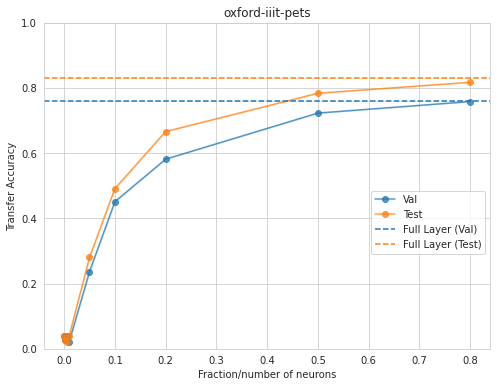

oxford-iiit-pets {0.0005: [0.040760867297649384], 0.001: [0.02717391401529312], 0.005: [0.03804347664117813], 0.01: [0.021739130839705467], 0.05: [0.23641304671764374], 0.1: [0.45108693838119507], 0.2: [0.58152174949646], 0.5: [0.7228260636329651], 0.8: [0.7581521272659302]}
drop_rate_0.2 drop_rate
resnet50 drop_rate_0.2 cifar10
Full Acc: [0.7249000072479248]
For 0.0005, acc: 0.1281999945640564 +/- 0.0
For 0.001, acc: 0.13220000267028809 +/- 0.0
For 0.005, acc: 0.2800000011920929 +/- 0.0
For 0.01, acc: 0.41190001368522644 +/- 0.0
For 0.05, acc: 0.6273999810218811 +/- 0.0
For 0.1, acc: 0.6568999886512756 +/- 0.0
For 0.2, acc: 0.6852999925613403 +/- 0.0
For 0.5, acc: 0.7178000211715698 +/- 0.0
For 0.8, acc: 0.7335000038146973 +/- 0.0



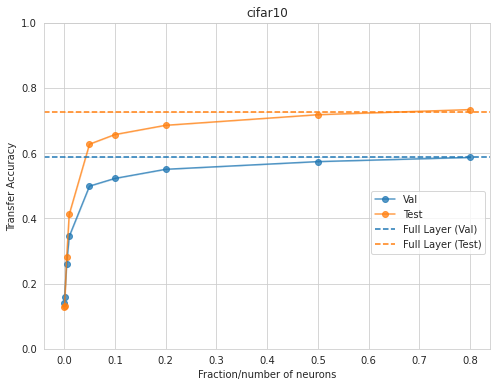

cifar10 {0.0005: [0.13979999721050262], 0.001: [0.15919999778270721], 0.005: [0.25999999046325684], 0.01: [0.34439998865127563], 0.05: [0.49879997968673706], 0.1: [0.5224000215530396], 0.2: [0.5504000186920166], 0.5: [0.5740000009536743], 0.8: [0.5867999792098999]}
resnet50 drop_rate_0.2 cifar100
Full Acc: [0.4165000021457672]
For 0.0005, acc: 0.013199999928474426 +/- 0.0
For 0.001, acc: 0.008999999612569809 +/- 0.0
For 0.005, acc: 0.02979999966919422 +/- 0.0
For 0.01, acc: 0.03739999979734421 +/- 0.0
For 0.05, acc: 0.1850000023841858 +/- 0.0
For 0.1, acc: 0.2759000062942505 +/- 0.0
For 0.2, acc: 0.319599986076355 +/- 0.0
For 0.5, acc: 0.37299999594688416 +/- 0.0
For 0.8, acc: 0.4056999981403351 +/- 0.0



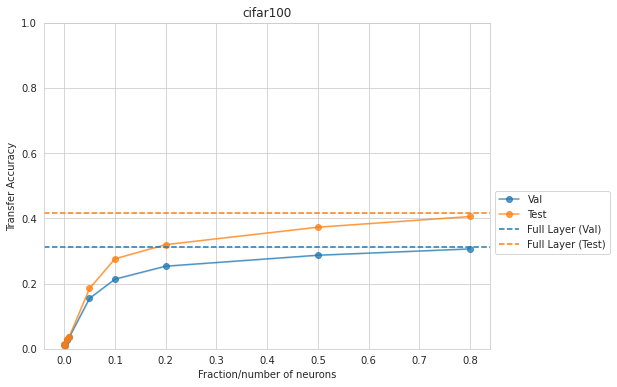

cifar100 {0.0005: [0.013000000268220901], 0.001: [0.012199999764561653], 0.005: [0.026000000536441803], 0.01: [0.03500000014901161], 0.05: [0.15459999442100525], 0.1: [0.2136000096797943], 0.2: [0.2533999979496002], 0.5: [0.28700000047683716], 0.8: [0.30640000104904175]}
resnet50 drop_rate_0.2 flowers
Full Acc: [0.12375996261835098]
For 0.0005, acc: 0.004065701737999916 +/- 0.0
For 0.001, acc: 0.0022767928894609213 +/- 0.0
For 0.005, acc: 0.016262806951999664 +/- 0.0
For 0.01, acc: 0.011709220707416534 +/- 0.0
For 0.05, acc: 0.0139860138297081 +/- 0.0
For 0.1, acc: 0.015937549993395805 +/- 0.0
For 0.2, acc: 0.02309318631887436 +/- 0.0
For 0.5, acc: 0.07464628666639328 +/- 0.0
For 0.8, acc: 0.09920312464237213 +/- 0.0



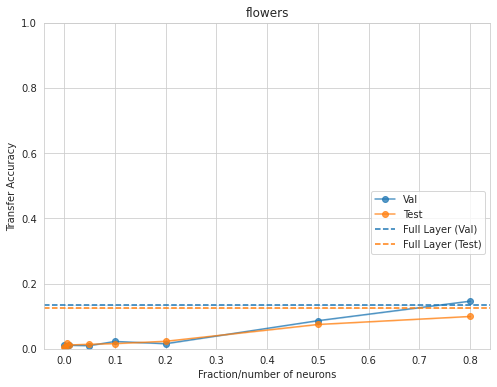

flowers {0.0005: [0.0117647061124444], 0.001: [0.0058823530562222], 0.005: [0.008823529817163944], 0.01: [0.010784314014017582], 0.05: [0.009803921915590763], 0.1: [0.022549020126461983], 0.2: [0.01568627543747425], 0.5: [0.08627451211214066], 0.8: [0.1460784375667572]}
resnet50 drop_rate_0.2 oxford-iiit-pets
Full Acc: [0.80975741147995]
For 0.0005, acc: 0.026437722146511078 +/- 0.0
For 0.001, acc: 0.027255382388830185 +/- 0.0
For 0.005, acc: 0.04769692197442055 +/- 0.0
For 0.01, acc: 0.03952030465006828 +/- 0.0
For 0.05, acc: 0.2842736542224884 +/- 0.0
For 0.1, acc: 0.4017443358898163 +/- 0.0
For 0.2, acc: 0.6707549691200256 +/- 0.0
For 0.5, acc: 0.7999454736709595 +/- 0.0
For 0.8, acc: 0.8157536387443542 +/- 0.0



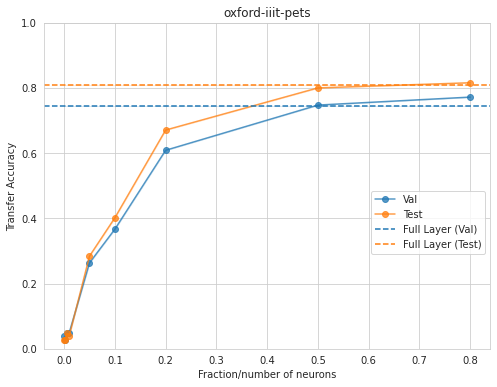

oxford-iiit-pets {0.0005: [0.03804347664117813], 0.001: [0.02717391401529312], 0.005: [0.04891304299235344], 0.01: [0.04891304299235344], 0.05: [0.26358693838119507], 0.1: [0.36684781312942505], 0.2: [0.6086956262588501], 0.5: [0.7472826242446899], 0.8: [0.77173912525177]}
drop_rate_0.6 drop_rate
resnet50 drop_rate_0.6 cifar10
Full Acc: [0.7172999978065491]
For 0.0005, acc: 0.1096000000834465 +/- 0.0
For 0.001, acc: 0.12809999287128448 +/- 0.0
For 0.005, acc: 0.27630001306533813 +/- 0.0
For 0.01, acc: 0.36980000138282776 +/- 0.0
For 0.05, acc: 0.5778999924659729 +/- 0.0
For 0.1, acc: 0.6359000205993652 +/- 0.0
For 0.2, acc: 0.663100004196167 +/- 0.0
For 0.5, acc: 0.6967999935150146 +/- 0.0
For 0.8, acc: 0.7124999761581421 +/- 0.0



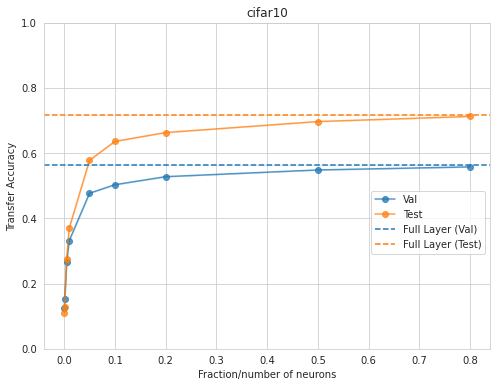

cifar10 {0.0005: [0.12559999525547028], 0.001: [0.15239998698234558], 0.005: [0.2662000060081482], 0.01: [0.33160001039505005], 0.05: [0.47699999809265137], 0.1: [0.5031999945640564], 0.2: [0.5277999639511108], 0.5: [0.5483999848365784], 0.8: [0.5577999949455261]}
resnet50 drop_rate_0.6 cifar100
Full Acc: [0.38040000200271606]
For 0.0005, acc: 0.01080000028014183 +/- 0.0
For 0.001, acc: 0.012400000356137753 +/- 0.0
For 0.005, acc: 0.017899999395012856 +/- 0.0
For 0.01, acc: 0.03500000014901161 +/- 0.0
For 0.05, acc: 0.15199999511241913 +/- 0.0
For 0.1, acc: 0.23569999635219574 +/- 0.0
For 0.2, acc: 0.29100000858306885 +/- 0.0
For 0.5, acc: 0.34220001101493835 +/- 0.0
For 0.8, acc: 0.3675999939441681 +/- 0.0



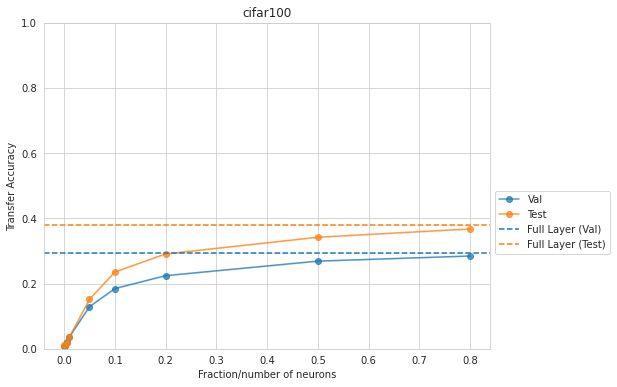

cifar100 {0.0005: [0.009999999776482582], 0.001: [0.008799999952316284], 0.005: [0.02199999988079071], 0.01: [0.03580000251531601], 0.05: [0.12939999997615814], 0.1: [0.18479999899864197], 0.2: [0.22439999878406525], 0.5: [0.26899999380111694], 0.8: [0.28460001945495605]}
resnet50 drop_rate_0.6 flowers
Full Acc: [0.08651813119649887]
For 0.0005, acc: 0.0087819155305624 +/- 0.0
For 0.001, acc: 0.0026020491495728493 +/- 0.0
For 0.005, acc: 0.003577817464247346 +/- 0.0
For 0.01, acc: 0.007968774996697903 +/- 0.0
For 0.05, acc: 0.012847617268562317 +/- 0.0
For 0.1, acc: 0.02244267426431179 +/- 0.0
For 0.2, acc: 0.021629532799124718 +/- 0.0
For 0.5, acc: 0.05122784152626991 +/- 0.0
For 0.8, acc: 0.07334525883197784 +/- 0.0



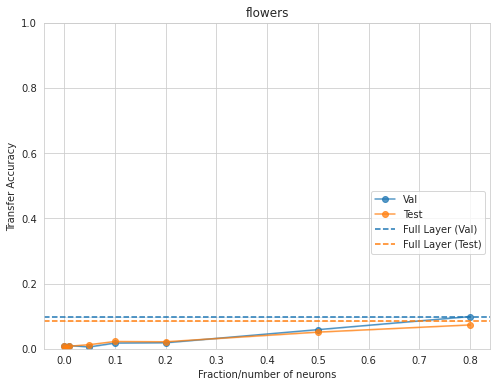

flowers {0.0005: [0.008823529817163944], 0.001: [0.0019607844296842813], 0.005: [0.0049019609577953815], 0.01: [0.009803921915590763], 0.05: [0.005882353521883488], 0.1: [0.01764705963432789], 0.2: [0.018627451732754707], 0.5: [0.05882353335618973], 0.8: [0.0990196093916893]}
resnet50 drop_rate_0.6 oxford-iiit-pets
Full Acc: [0.8214772343635559]
For 0.0005, acc: 0.031616244465112686 +/- 0.0
For 0.001, acc: 0.027255382388830185 +/- 0.0
For 0.005, acc: 0.04415372014045715 +/- 0.0
For 0.01, acc: 0.036249659955501556 +/- 0.0
For 0.05, acc: 0.3243390619754791 +/- 0.0
For 0.1, acc: 0.4726083278656006 +/- 0.0
For 0.2, acc: 0.6405014991760254 +/- 0.0
For 0.5, acc: 0.7923139929771423 +/- 0.0
For 0.8, acc: 0.8165712952613831 +/- 0.0



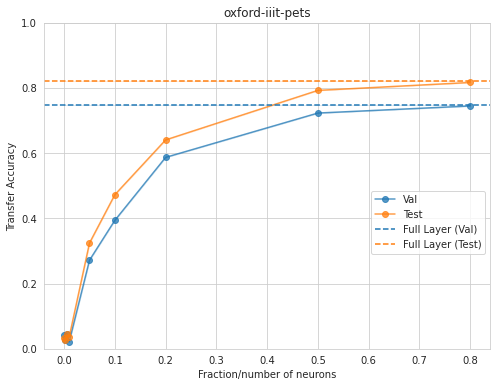

oxford-iiit-pets {0.0005: [0.043478257954120636], 0.001: [0.02717391401529312], 0.005: [0.04619564861059189], 0.01: [0.021739130839705467], 0.05: [0.27173912525177], 0.1: [0.39402174949645996], 0.2: [0.5869565010070801], 0.5: [0.7228261232376099], 0.8: [0.7445652484893799]}
decov_0.0001 drop_rate
drop_rate_0.4 drop_rate
resnet50 drop_rate_0.4 cifar10
Full Acc: [0.725600004196167]
For 0.0005, acc: 0.10419999808073044 +/- 0.0
For 0.001, acc: 0.1120000034570694 +/- 0.0
For 0.005, acc: 0.2874000072479248 +/- 0.0
For 0.01, acc: 0.36070001125335693 +/- 0.0
For 0.05, acc: 0.5972999930381775 +/- 0.0
For 0.1, acc: 0.6485999822616577 +/- 0.0
For 0.2, acc: 0.6779999732971191 +/- 0.0
For 0.5, acc: 0.7096999883651733 +/- 0.0
For 0.8, acc: 0.7224000096321106 +/- 0.0



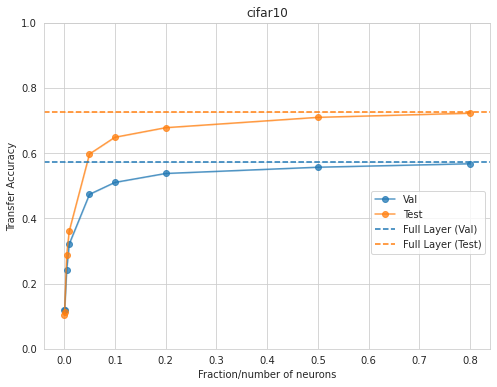

cifar10 {0.0005: [0.11980000138282776], 0.001: [0.11840000003576279], 0.005: [0.2409999966621399], 0.01: [0.32099997997283936], 0.05: [0.47360000014305115], 0.1: [0.510200023651123], 0.2: [0.537600040435791], 0.5: [0.5568000078201294], 0.8: [0.5673999786376953]}
resnet50 drop_rate_0.4 cifar100
Full Acc: [0.4052000045776367]
For 0.0005, acc: 0.006800000090152025 +/- 0.0
For 0.001, acc: 0.006800000090152025 +/- 0.0
For 0.005, acc: 0.018799999728798866 +/- 0.0
For 0.01, acc: 0.03370000049471855 +/- 0.0
For 0.05, acc: 0.15610000491142273 +/- 0.0
For 0.1, acc: 0.2621000111103058 +/- 0.0
For 0.2, acc: 0.3028999865055084 +/- 0.0
For 0.5, acc: 0.36039999127388 +/- 0.0
For 0.8, acc: 0.3937999904155731 +/- 0.0



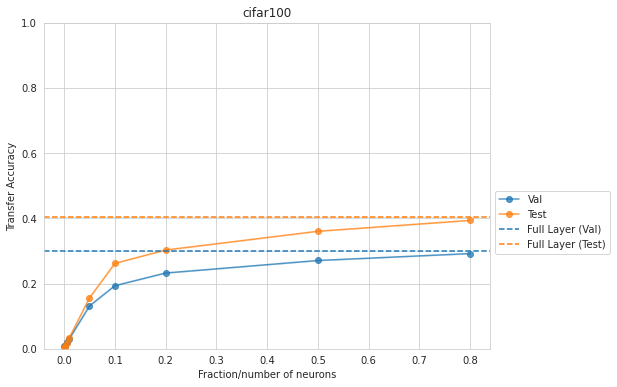

cifar100 {0.0005: [0.007999999448657036], 0.001: [0.008999999612569809], 0.005: [0.02019999921321869], 0.01: [0.03020000085234642], 0.05: [0.13159999251365662], 0.1: [0.19359999895095825], 0.2: [0.23240000009536743], 0.5: [0.27079999446868896], 0.8: [0.2919999957084656]}
resnet50 drop_rate_0.4 flowers
Full Acc: [0.13611969351768494]
For 0.0005, acc: 0.0026020491495728493 +/- 0.0
For 0.001, acc: 0.004878842271864414 +/- 0.0
For 0.005, acc: 0.005691982340067625 +/- 0.0
For 0.01, acc: 0.007155634928494692 +/- 0.0
For 0.05, acc: 0.010733452625572681 +/- 0.0
For 0.1, acc: 0.02878516912460327 +/- 0.0
For 0.2, acc: 0.010733452625572681 +/- 0.0
For 0.5, acc: 0.0735078901052475 +/- 0.0
For 0.8, acc: 0.10261831432580948 +/- 0.0



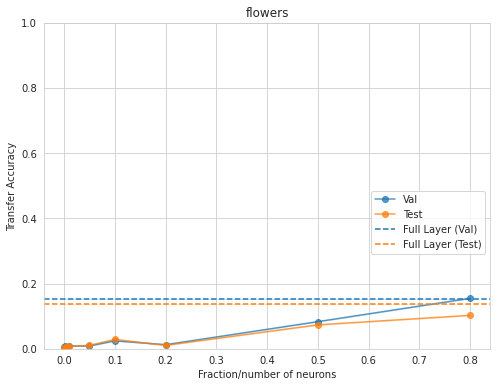

flowers {0.0005: [0.0068627456203103065], 0.001: [0.007843137718737125], 0.005: [0.0049019609577953815], 0.01: [0.008823529817163944], 0.05: [0.008823529817163944], 0.1: [0.02450980432331562], 0.2: [0.01274509821087122], 0.5: [0.0833333358168602], 0.8: [0.15490196645259857]}
resnet50 drop_rate_0.4 oxford-iiit-pets
Full Acc: [0.8233851194381714]
For 0.0005, acc: 0.054238211363554 +/- 0.0
For 0.001, acc: 0.027527937665581703 +/- 0.0
For 0.005, acc: 0.053420551121234894 +/- 0.0
For 0.01, acc: 0.04306350648403168 +/- 0.0
For 0.05, acc: 0.27854999899864197 +/- 0.0
For 0.1, acc: 0.3987462520599365 +/- 0.0
For 0.2, acc: 0.657944917678833 +/- 0.0
For 0.5, acc: 0.8056691288948059 +/- 0.0
For 0.8, acc: 0.8179340362548828 +/- 0.0



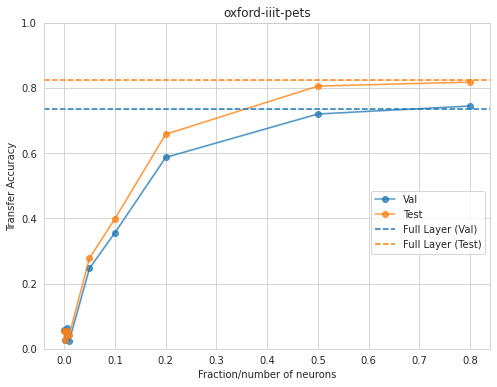

oxford-iiit-pets {0.0005: [0.057065218687057495], 0.001: [0.02717391401529312], 0.005: [0.06521739065647125], 0.01: [0.02445652149617672], 0.05: [0.24728260934352875], 0.1: [0.35597825050354004], 0.2: [0.5869565010070801], 0.5: [0.7201087474822998], 0.8: [0.7445652484893799]}
drop_rate_0.8 drop_rate
resnet50 drop_rate_0.8 cifar10
Full Acc: [0.6812999844551086]
For 0.0005, acc: 0.15549999475479126 +/- 0.0
For 0.001, acc: 0.18279999494552612 +/- 0.0
For 0.005, acc: 0.32510000467300415 +/- 0.0
For 0.01, acc: 0.39239999651908875 +/- 0.0
For 0.05, acc: 0.5454999804496765 +/- 0.0
For 0.1, acc: 0.597000002861023 +/- 0.0
For 0.2, acc: 0.6255000233650208 +/- 0.0
For 0.5, acc: 0.661300003528595 +/- 0.0
For 0.8, acc: 0.6747000217437744 +/- 0.0



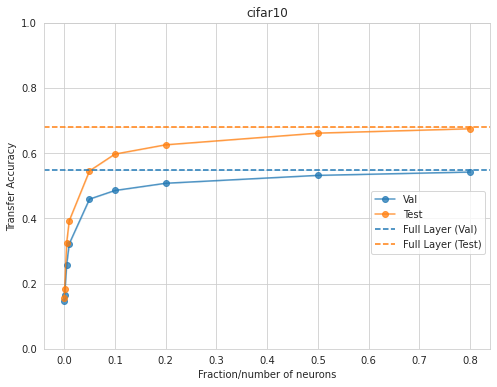

cifar10 {0.0005: [0.1477999985218048], 0.001: [0.164000004529953], 0.005: [0.2580000162124634], 0.01: [0.32179999351501465], 0.05: [0.45899999141693115], 0.1: [0.4854000210762024], 0.2: [0.507599949836731], 0.5: [0.5318000316619873], 0.8: [0.5419999957084656]}
resnet50 drop_rate_0.8 cifar100
Full Acc: [0.35519999265670776]
For 0.0005, acc: 0.010700000450015068 +/- 0.0
For 0.001, acc: 0.010499999858438969 +/- 0.0
For 0.005, acc: 0.02239999920129776 +/- 0.0
For 0.01, acc: 0.03629999980330467 +/- 0.0
For 0.05, acc: 0.14319999516010284 +/- 0.0
For 0.1, acc: 0.21879999339580536 +/- 0.0
For 0.2, acc: 0.2687000036239624 +/- 0.0
For 0.5, acc: 0.32170000672340393 +/- 0.0
For 0.8, acc: 0.34630000591278076 +/- 0.0



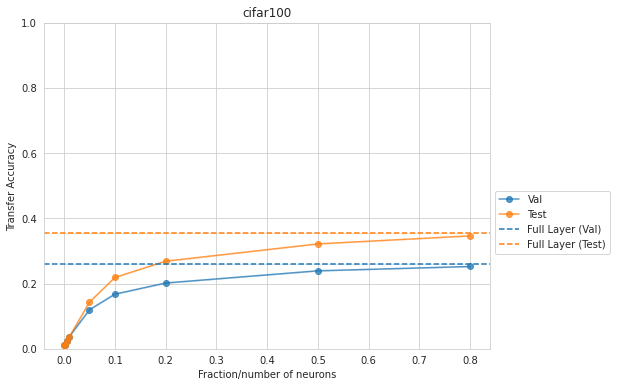

cifar100 {0.0005: [0.010400000028312206], 0.001: [0.011599999852478504], 0.005: [0.024000000208616257], 0.01: [0.03720000013709068], 0.05: [0.11980000138282776], 0.1: [0.16760000586509705], 0.2: [0.20180000364780426], 0.5: [0.23919999599456787], 0.8: [0.2524000108242035]}
resnet50 drop_rate_0.8 flowers
Full Acc: [0.04342169314622879]
For 0.0005, acc: 0.002439421135932207 +/- 0.0
For 0.001, acc: 0.007643519435077906 +/- 0.0
For 0.005, acc: 0.01967799663543701 +/- 0.0
For 0.01, acc: 0.006505122873932123 +/- 0.0
For 0.05, acc: 0.008131403475999832 +/- 0.0
For 0.1, acc: 0.0074808914214372635 +/- 0.0
For 0.2, acc: 0.007806147448718548 +/- 0.0
For 0.5, acc: 0.035615548491477966 +/- 0.0
For 0.8, acc: 0.047162141650915146 +/- 0.0



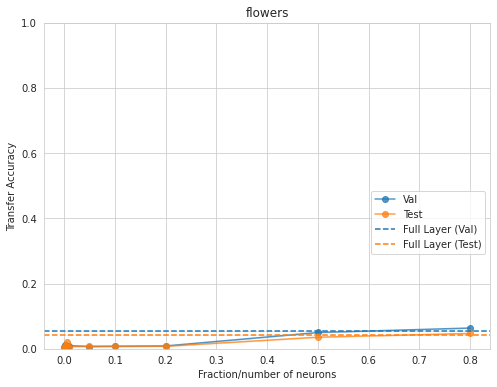

flowers {0.0005: [0.0058823530562222], 0.001: [0.010784314014017582], 0.005: [0.009803921915590763], 0.01: [0.009803921915590763], 0.05: [0.006862745154649019], 0.1: [0.007843137718737125], 0.2: [0.008823529817163944], 0.5: [0.05000000074505806], 0.8: [0.06372549384832382]}
resnet50 drop_rate_0.8 oxford-iiit-pets
Full Acc: [0.8127555251121521]
For 0.0005, acc: 0.022076860070228577 +/- 0.0
For 0.001, acc: 0.030253475531935692 +/- 0.0
For 0.005, acc: 0.054238211363554 +/- 0.0
For 0.01, acc: 0.03815753757953644 +/- 0.0
For 0.05, acc: 0.28291088342666626 +/- 0.0
For 0.1, acc: 0.4486235976219177 +/- 0.0
For 0.2, acc: 0.5966203212738037 +/- 0.0
For 0.5, acc: 0.774325430393219 +/- 0.0
For 0.8, acc: 0.8051239848136902 +/- 0.0



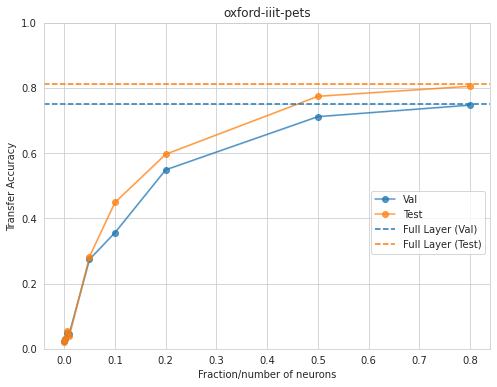

oxford-iiit-pets {0.0005: [0.02445652149617672], 0.001: [0.029891304671764374], 0.005: [0.04891304299235344], 0.01: [0.04619565233588219], 0.05: [0.2744565010070801], 0.1: [0.35597825050354004], 0.2: [0.5489130020141602], 0.5: [0.7119565010070801], 0.8: [0.7472826242446899]}
drop_rate_0.1 drop_rate
resnet50 drop_rate_0.1 cifar10
Full Acc: [0.7468000054359436]
For 0.0005, acc: 0.1535000056028366 +/- 0.0
For 0.001, acc: 0.17669999599456787 +/- 0.0
For 0.005, acc: 0.31529998779296875 +/- 0.0
For 0.01, acc: 0.4334999918937683 +/- 0.0
For 0.05, acc: 0.6582000255584717 +/- 0.0
For 0.1, acc: 0.7059999704360962 +/- 0.0
For 0.2, acc: 0.7322999835014343 +/- 0.0
For 0.5, acc: 0.7692999839782715 +/- 0.0
For 0.8, acc: 0.7567999958992004 +/- 0.0



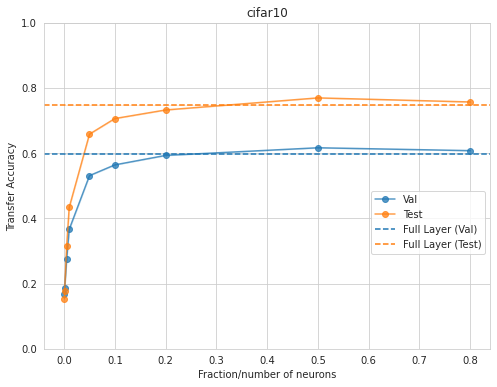

cifar10 {0.0005: [0.16740000247955322], 0.001: [0.1858000010251999], 0.005: [0.2752000093460083], 0.01: [0.3662000000476837], 0.05: [0.531000018119812], 0.1: [0.5640000104904175], 0.2: [0.5929999947547913], 0.5: [0.6164000034332275], 0.8: [0.6075999736785889]}
resnet50 drop_rate_0.1 cifar100
Full Acc: [0.5031999945640564]
For 0.0005, acc: 0.013299999758601189 +/- 0.0
For 0.001, acc: 0.019300000742077827 +/- 0.0
For 0.005, acc: 0.029899999499320984 +/- 0.0
For 0.01, acc: 0.04989999905228615 +/- 0.0
For 0.05, acc: 0.21369999647140503 +/- 0.0
For 0.1, acc: 0.31520000100135803 +/- 0.0
For 0.2, acc: 0.35830000042915344 +/- 0.0
For 0.5, acc: 0.4514000117778778 +/- 0.0
For 0.8, acc: 0.48489999771118164 +/- 0.0



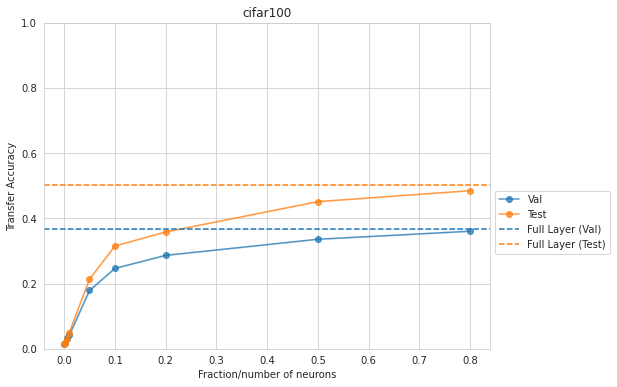

cifar100 {0.0005: [0.015200000256299973], 0.001: [0.016599999740719795], 0.005: [0.03180000185966492], 0.01: [0.041200000792741776], 0.05: [0.17880000174045563], 0.1: [0.24660000205039978], 0.2: [0.2865999937057495], 0.5: [0.3360000252723694], 0.8: [0.36059999465942383]}
resnet50 drop_rate_0.1 flowers
Full Acc: [0.18523336946964264]
For 0.0005, acc: 0.0034151894506067038 +/- 0.0
For 0.001, acc: 0.0037404457107186317 +/- 0.0
For 0.005, acc: 0.0022767928894609213 +/- 0.0
For 0.01, acc: 0.008294031955301762 +/- 0.0
For 0.05, acc: 0.01138396468013525 +/- 0.0
For 0.1, acc: 0.0074808914214372635 +/- 0.0
For 0.2, acc: 0.0175638310611248 +/- 0.0
For 0.5, acc: 0.08228980004787445 +/- 0.0
For 0.8, acc: 0.11351439356803894 +/- 0.0



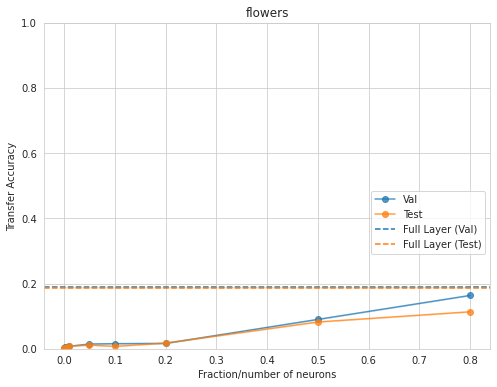

flowers {0.0005: [0.003921568859368563], 0.001: [0.005882353521883488], 0.005: [0.002941176760941744], 0.01: [0.007843137718737125], 0.05: [0.014705883339047432], 0.1: [0.01568627543747425], 0.2: [0.01666666753590107], 0.5: [0.09019608050584793], 0.8: [0.16372549533843994]}
resnet50 drop_rate_0.1 oxford-iiit-pets
Full Acc: [0.8623602986335754]
For 0.0005, acc: 0.041428182274103165 +/- 0.0
For 0.001, acc: 0.027255382388830185 +/- 0.0
For 0.005, acc: 0.054238211363554 +/- 0.0
For 0.01, acc: 0.05233033373951912 +/- 0.0
For 0.05, acc: 0.3019896447658539 +/- 0.0
For 0.1, acc: 0.4488961696624756 +/- 0.0
For 0.2, acc: 0.7258108258247375 +/- 0.0
For 0.5, acc: 0.8432815670967102 +/- 0.0
For 0.8, acc: 0.8659034967422485 +/- 0.0



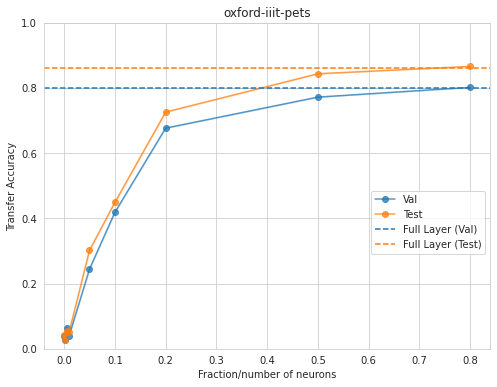

oxford-iiit-pets {0.0005: [0.040760867297649384], 0.001: [0.02717391401529312], 0.005: [0.06521739065647125], 0.01: [0.040760867297649384], 0.05: [0.2445652186870575], 0.1: [0.41847825050354004], 0.2: [0.676630437374115], 0.5: [0.77173912525177], 0.8: [0.801630437374115]}
drop_rate_0.5 drop_rate
resnet50 drop_rate_0.5 cifar10
Full Acc: [0.7706999778747559]
For 0.0005, acc: 0.12319999933242798 +/- 0.0
For 0.001, acc: 0.1446000039577484 +/- 0.0
For 0.005, acc: 0.2849000096321106 +/- 0.0
For 0.01, acc: 0.3619000017642975 +/- 0.0
For 0.05, acc: 0.6589000225067139 +/- 0.0
For 0.1, acc: 0.7063000202178955 +/- 0.0
For 0.2, acc: 0.7301999926567078 +/- 0.0
For 0.5, acc: 0.7562000155448914 +/- 0.0
For 0.8, acc: 0.7677000164985657 +/- 0.0



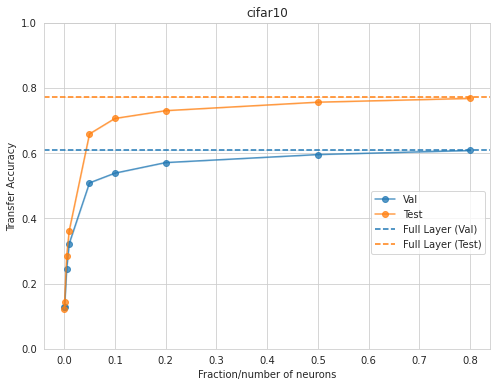

cifar10 {0.0005: [0.12759999930858612], 0.001: [0.12880000472068787], 0.005: [0.24380001425743103], 0.01: [0.32260000705718994], 0.05: [0.5088000297546387], 0.1: [0.538599967956543], 0.2: [0.5709999799728394], 0.5: [0.5956000089645386], 0.8: [0.6080000400543213]}
resnet50 drop_rate_0.5 cifar100
Full Acc: [0.4607999920845032]
For 0.0005, acc: 0.008700000122189522 +/- 0.0
For 0.001, acc: 0.01489999983459711 +/- 0.0
For 0.005, acc: 0.02449999935925007 +/- 0.0
For 0.01, acc: 0.039799999445676804 +/- 0.0
For 0.05, acc: 0.18250000476837158 +/- 0.0
For 0.1, acc: 0.2856999933719635 +/- 0.0
For 0.2, acc: 0.34130001068115234 +/- 0.0
For 0.5, acc: 0.4140999913215637 +/- 0.0
For 0.8, acc: 0.4498000144958496 +/- 0.0



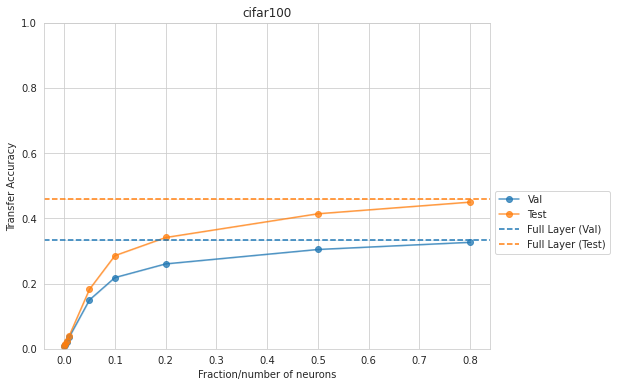

cifar100 {0.0005: [0.009399999864399433], 0.001: [0.011800000444054604], 0.005: [0.02160000056028366], 0.01: [0.03579999879002571], 0.05: [0.15000000596046448], 0.1: [0.2184000015258789], 0.2: [0.2603999972343445], 0.5: [0.3046000003814697], 0.8: [0.32660001516342163]}
resnet50 drop_rate_0.5 flowers
Full Acc: [0.09188485890626907]
For 0.0005, acc: 0.005529354326426983 +/- 0.0
For 0.001, acc: 0.004065701737999916 +/- 0.0
For 0.005, acc: 0.004065701737999916 +/- 0.0
For 0.01, acc: 0.006505122873932123 +/- 0.0
For 0.05, acc: 0.016262806951999664 +/- 0.0
For 0.1, acc: 0.021141648292541504 +/- 0.0
For 0.2, acc: 0.02341844141483307 +/- 0.0
For 0.5, acc: 0.06781590729951859 +/- 0.0
For 0.8, acc: 0.0860302522778511 +/- 0.0



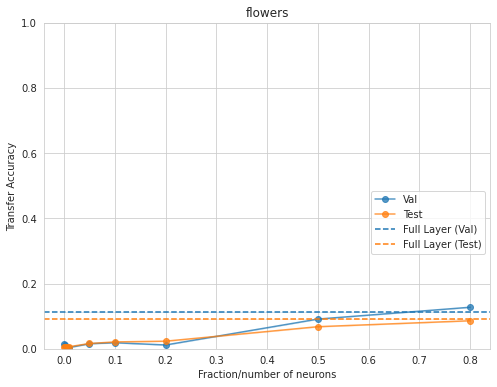

flowers {0.0005: [0.014705883339047432], 0.001: [0.010784314014017582], 0.005: [0.003921568859368563], 0.01: [0.003921568859368563], 0.05: [0.01568627543747425], 0.1: [0.018627451732754707], 0.2: [0.0117647061124444], 0.5: [0.09117647260427475], 0.8: [0.12745098769664764]}
resnet50 drop_rate_0.5 oxford-iiit-pets
Full Acc: [0.8759880065917969]
For 0.0005, acc: 0.011719814501702785 +/- 0.0
For 0.001, acc: 0.02861815132200718 +/- 0.0
For 0.005, acc: 0.06323248893022537 +/- 0.0
For 0.01, acc: 0.07686018198728561 +/- 0.0
For 0.05, acc: 0.32243117690086365 +/- 0.0
For 0.1, acc: 0.5017716288566589 +/- 0.0
For 0.2, acc: 0.730989396572113 +/- 0.0
For 0.5, acc: 0.8432815670967102 +/- 0.0
For 0.8, acc: 0.8727173805236816 +/- 0.0



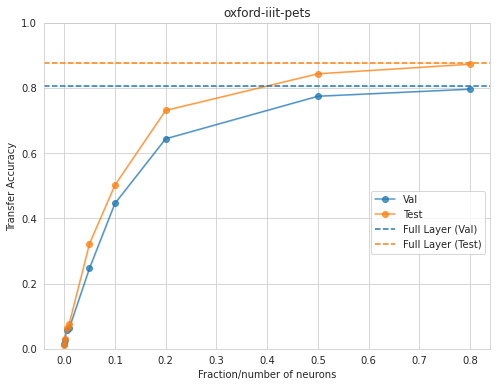

oxford-iiit-pets {0.0005: [0.01358695700764656], 0.001: [0.02717391401529312], 0.005: [0.057065218687057495], 0.01: [0.0625], 0.05: [0.24728260934352875], 0.1: [0.44565218687057495], 0.2: [0.64402174949646], 0.5: [0.7744565010070801], 0.8: [0.7961956262588501]}
Uploading results in ['results/decorrelation_analysis/imagenet'] to contact.mpi-sws.org...
Uploading 36 files to server
copying results/decorrelation_analysis/imagenet/resnet50_cifar10_bs_1024_drop_rate_0.3_random.png to /home/vnanda/public_html/results/partially_inverted_reps/decorrelation_analysis/imagenet/resnet50_cifar10_bs_1024_drop_rate_0.3_random.png
copying results/decorrelation_analysis/imagenet/resnet50_oxford-iiit-pets_bs_1024_drop_rate_0.6_random.png to /home/vnanda/public_html/results/partially_inverted_reps/decorrelation_analysis/imagenet/resnet50_oxford-iiit-pets_bs_1024_drop_rate_0.6_random.png
copying results/decorrelation_analysis/imagenet/resnet50_cifar100_bs_1024_drop_rate_0.2_random.png to /home/vnanda/publi

In [10]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
FINETUNE_MODE = 'random'
ANALYSIS_TYPE = 'drop_rate'
BATCH_SIZE = 1024
resnet50dropout_to_fracwise_accs = results(MODEL, SOURCE_DATASET, 
                                    analysis_type=ANALYSIS_TYPE, 
                                    finetune_bs=BATCH_SIZE)

In [11]:
resnet50dropout_to_fracwise_accs

{'resnet50-drop_rate_0.3-cifar10': {0.0005: [0.12530000507831573],
  0.001: [0.1543000042438507],
  0.005: [0.26030001044273376],
  0.01: [0.3695000112056732],
  0.05: [0.6008999943733215],
  0.1: [0.6565999984741211],
  0.2: [0.6830999851226807],
  0.5: [0.7161999940872192],
  0.8: [0.7290999889373779],
  1.0: [0.7350000143051147]},
 'resnet50-drop_rate_0.3-cifar100': {0.0005: [0.009999999776482582],
  0.001: [0.010300000198185444],
  0.005: [0.03009999915957451],
  0.01: [0.04100000113248825],
  0.05: [0.15189999341964722],
  0.1: [0.26660001277923584],
  0.2: [0.3102000057697296],
  0.5: [0.3684000074863434],
  0.8: [0.39329999685287476],
  1.0: [0.4065999984741211]},
 'resnet50-drop_rate_0.3-flowers': {0.0005: [0.004878842271864414],
  0.001: [0.004065701737999916],
  0.005: [0.018702227622270584],
  0.01: [0.006505122873932123],
  0.05: [0.00943242758512497],
  0.1: [0.011709220707416534],
  0.2: [0.0419580414891243],
  0.5: [0.05919661745429039],
  0.8: [0.08960806578397751],
  1

drop_rate_0.3 decov
drop_rate_0.7 decov
drop_rate_0.2 decov
drop_rate_0.6 decov
decov_0.0001 decov
resnet50 decov_0.0001 cifar10
Full Acc: [0.680899977684021]
For 0.005, acc: 0.31150001287460327 +/- 0.0
For 0.01, acc: 0.38359999656677246 +/- 0.0
For 0.05, acc: 0.5975000262260437 +/- 0.0
For 0.1, acc: 0.6514999866485596 +/- 0.0
For 0.2, acc: 0.6832000017166138 +/- 0.0
For 0.3, acc: 0.6949999928474426 +/- 0.0
For 0.5, acc: 0.7135999798774719 +/- 0.0
For 0.8, acc: 0.695900022983551 +/- 0.0



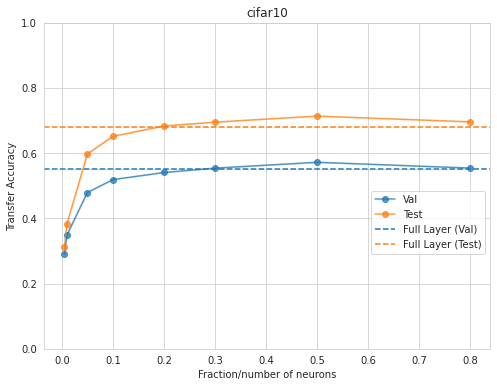

cifar10 {0.005: [0.28939998149871826], 0.01: [0.3489999771118164], 0.05: [0.47920000553131104], 0.1: [0.5188000202178955], 0.2: [0.5406000018119812], 0.3: [0.5540000200271606], 0.5: [0.5720000267028809], 0.8: [0.5541999936103821]}
resnet50 decov_0.0001 cifar100
Full Acc: [0.4203000068664551]
For 0.005, acc: 0.022600000724196434 +/- 0.0
For 0.01, acc: 0.04410000145435333 +/- 0.0
For 0.05, acc: 0.1843000054359436 +/- 0.0
For 0.1, acc: 0.26460000872612 +/- 0.0
For 0.2, acc: 0.31540000438690186 +/- 0.0
For 0.3, acc: 0.3359000086784363 +/- 0.0
For 0.5, acc: 0.37389999628067017 +/- 0.0
For 0.8, acc: 0.40299999713897705 +/- 0.0



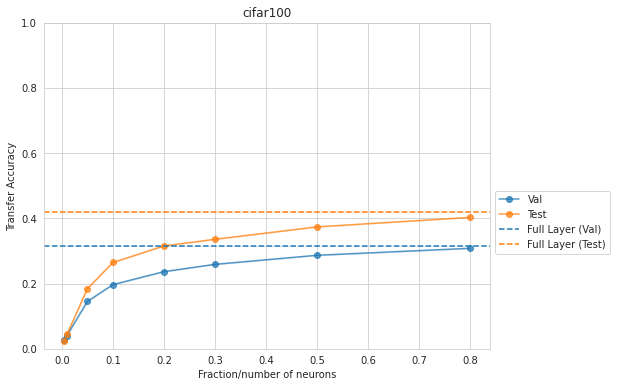

cifar100 {0.005: [0.026399999856948853], 0.01: [0.0406000018119812], 0.05: [0.1451999992132187], 0.1: [0.19679999351501465], 0.2: [0.23659999668598175], 0.3: [0.2590000033378601], 0.5: [0.28679999709129333], 0.8: [0.30820000171661377]}
resnet50 decov_0.0001 flowers
Full Acc: [0.11026182770729065]
For 0.005, acc: 0.012197105213999748 +/- 0.0
For 0.01, acc: 0.009920312091708183 +/- 0.0
For 0.05, acc: 0.017075946554541588 +/- 0.0
For 0.1, acc: 0.015449666418135166 +/- 0.0
For 0.2, acc: 0.02000325173139572 +/- 0.0
For 0.3, acc: 0.03545292094349861 +/- 0.0
For 0.5, acc: 0.07269474864006042 +/- 0.0
For 0.8, acc: 0.11058709025382996 +/- 0.0



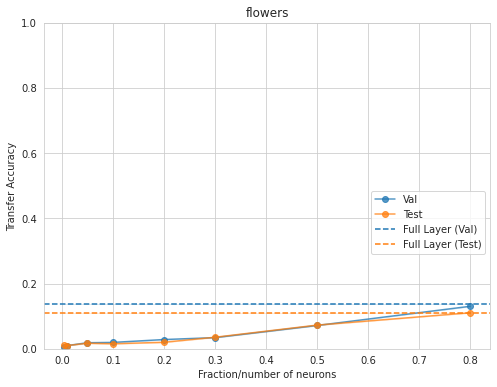

flowers {0.005: [0.0068627456203103065], 0.01: [0.009803921915590763], 0.05: [0.018627451732754707], 0.1: [0.019607843831181526], 0.2: [0.028431372717022896], 0.3: [0.03431372717022896], 0.5: [0.07156863063573837], 0.8: [0.1303921639919281]}
resnet50 decov_0.0001 oxford-iiit-pets
Full Acc: [0.8255655765533447]
For 0.005, acc: 0.027527937665581703 +/- 0.0
For 0.01, acc: 0.03297901153564453 +/- 0.0
For 0.05, acc: 0.17715999484062195 +/- 0.0
For 0.1, acc: 0.26737532019615173 +/- 0.0
For 0.2, acc: 0.5936222672462463 +/- 0.0
For 0.3, acc: 0.6876533031463623 +/- 0.0
For 0.5, acc: 0.7887707948684692 +/- 0.0
For 0.8, acc: 0.8064867854118347 +/- 0.0



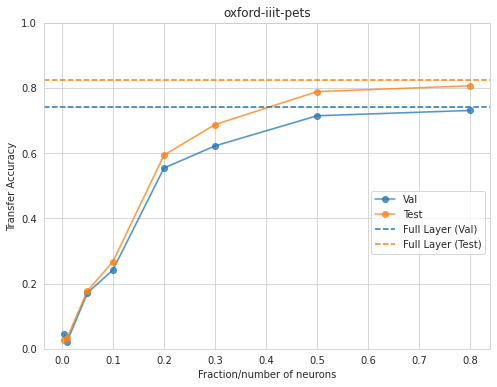

oxford-iiit-pets {0.005: [0.04619565233588219], 0.01: [0.021739130839705467], 0.05: [0.17119565606117249], 0.1: [0.24184781312942505], 0.2: [0.5543478727340698], 0.3: [0.6222826242446899], 0.5: [0.7146738767623901], 0.8: [0.73097825050354]}
drop_rate_0.4 decov
drop_rate_0.8 decov
drop_rate_0.1 decov
drop_rate_0.5 decov
Uploading results in ['results/decorrelation_analysis/imagenet'] to contact.mpi-sws.org...
Uploading 36 files to server
copying results/decorrelation_analysis/imagenet/resnet50_cifar10_bs_1024_drop_rate_0.3_random.png to /home/vnanda/public_html/results/partially_inverted_reps/decorrelation_analysis/imagenet/resnet50_cifar10_bs_1024_drop_rate_0.3_random.png
copying results/decorrelation_analysis/imagenet/resnet50_oxford-iiit-pets_bs_1024_drop_rate_0.6_random.png to /home/vnanda/public_html/results/partially_inverted_reps/decorrelation_analysis/imagenet/resnet50_oxford-iiit-pets_bs_1024_drop_rate_0.6_random.png
copying results/decorrelation_analysis/imagenet/resnet50_cifa

In [12]:
SOURCE_DATASET = 'imagenet'
MODEL = 'resnet50'
FINETUNE_MODE = 'random'
ANALYSIS_TYPE = 'decov'
BATCH_SIZE = 1024
resnet50decov_to_fracwise_accs = results(MODEL, SOURCE_DATASET, 
                                    analysis_type=ANALYSIS_TYPE, 
                                    finetune_bs=BATCH_SIZE)

In [15]:
resnet50_allres = {**resnet50decov_to_fracwise_accs, **resnet50dropout_to_fracwise_accs}

[True, True, True, True]


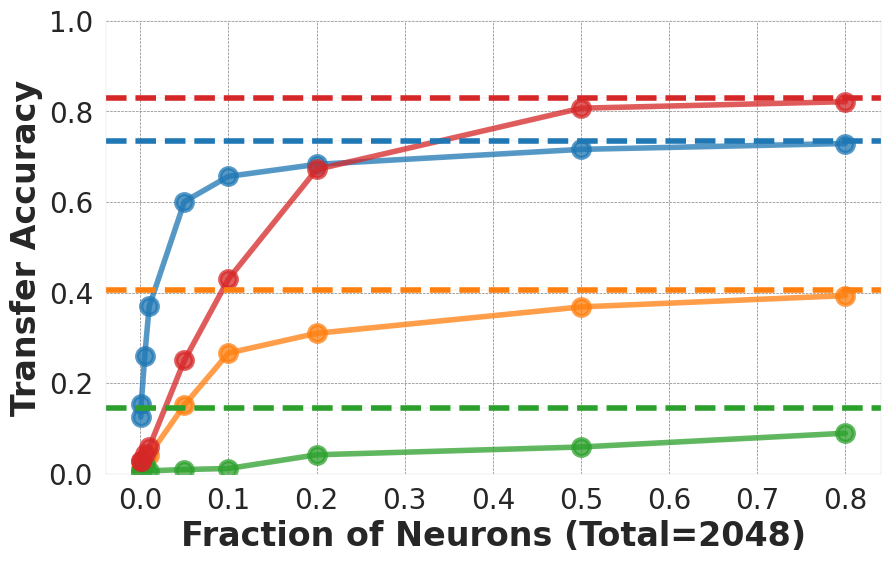

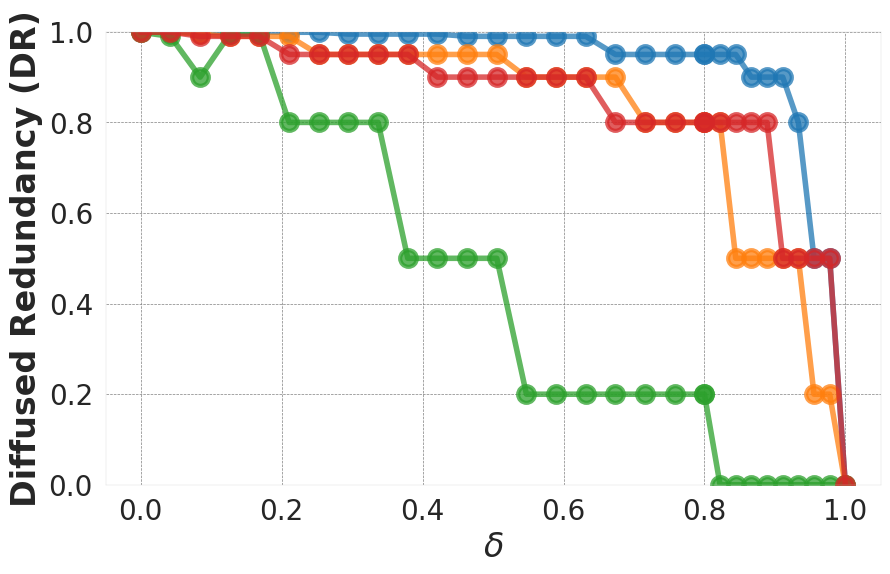

[True, True, True, True]


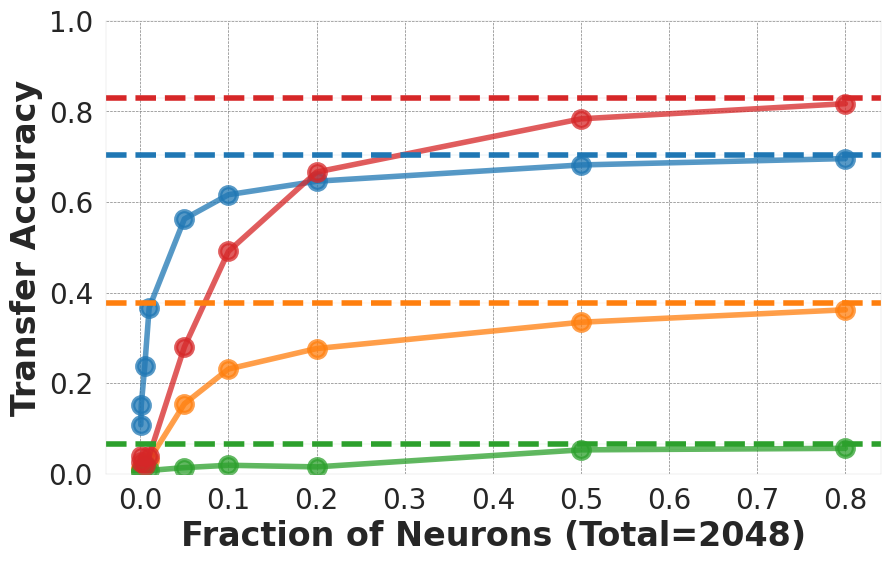

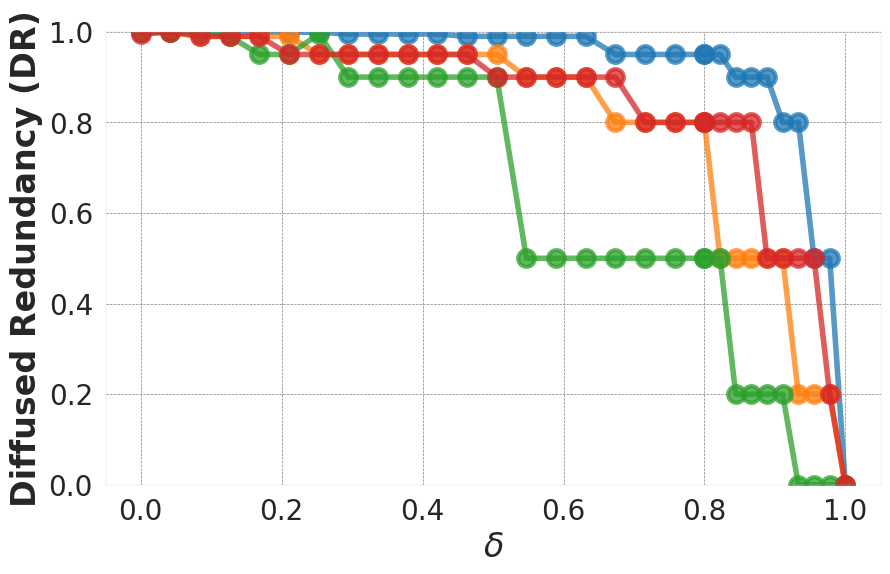

[True, True, True, True]


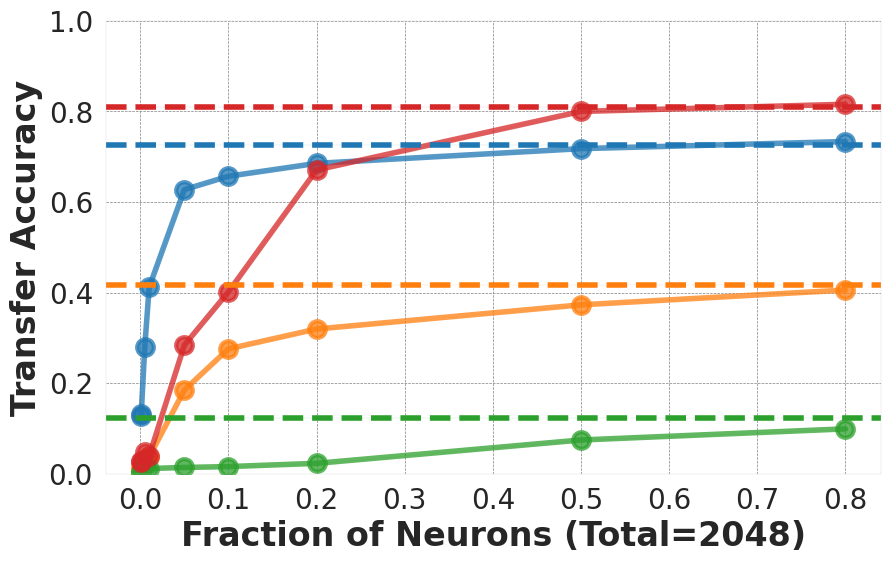

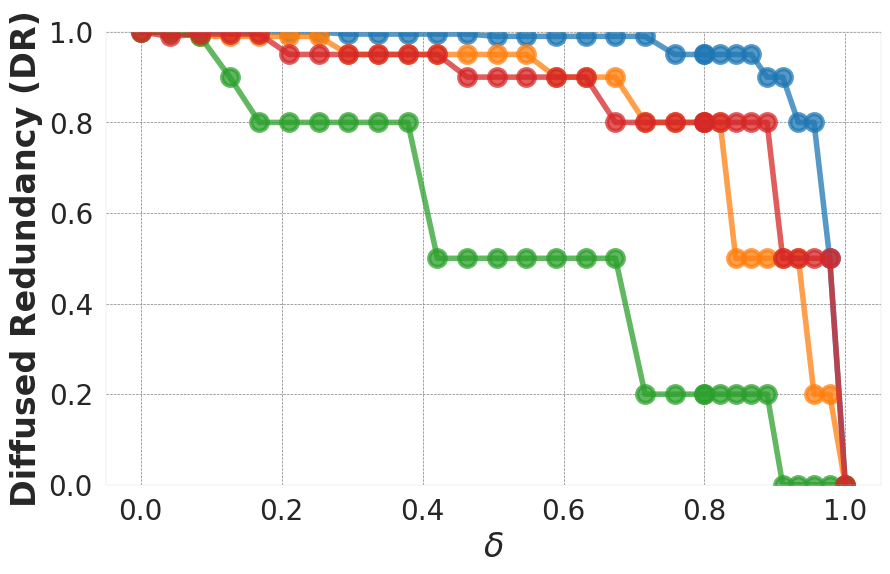

[True, True, True, True]


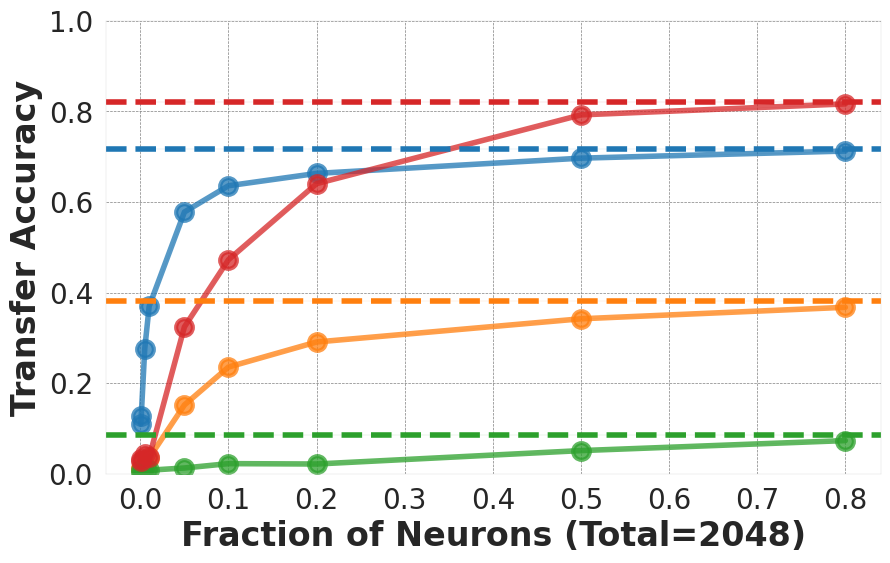

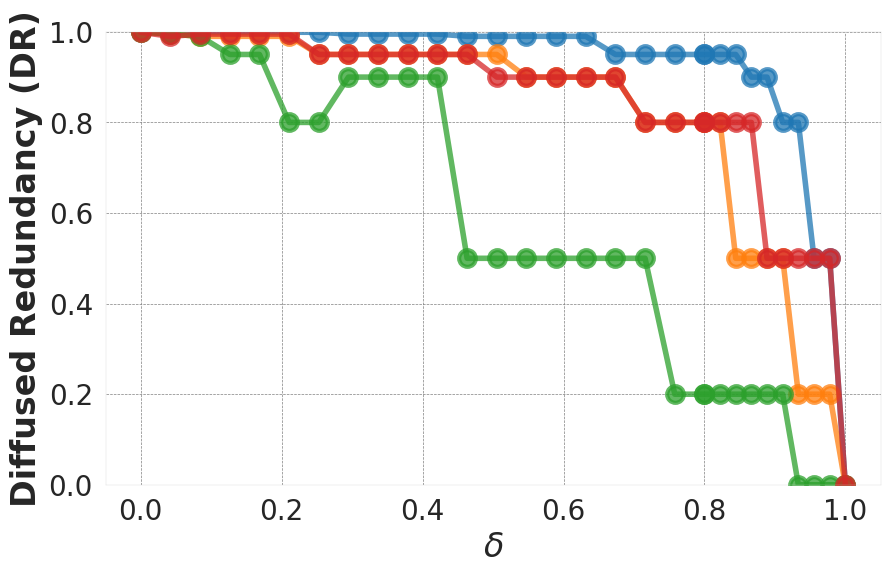

[True, True, True, True]


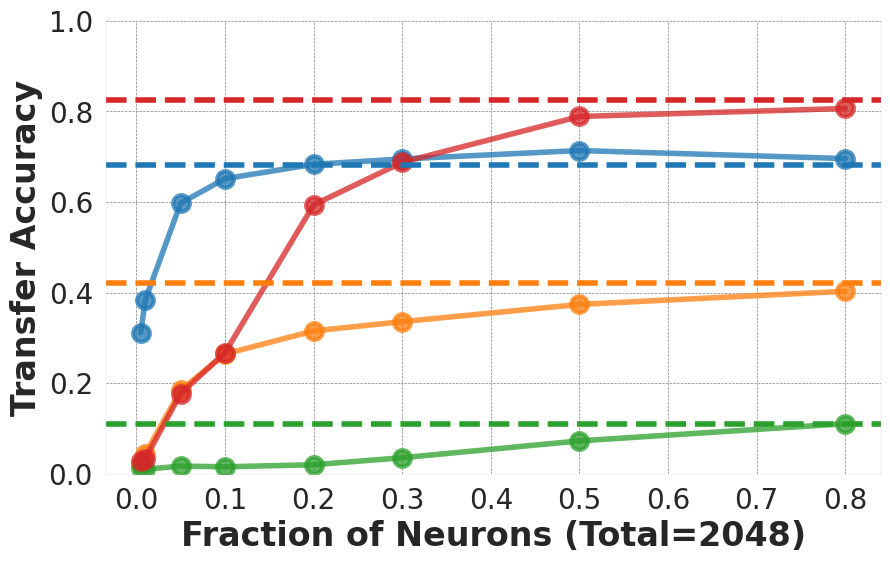

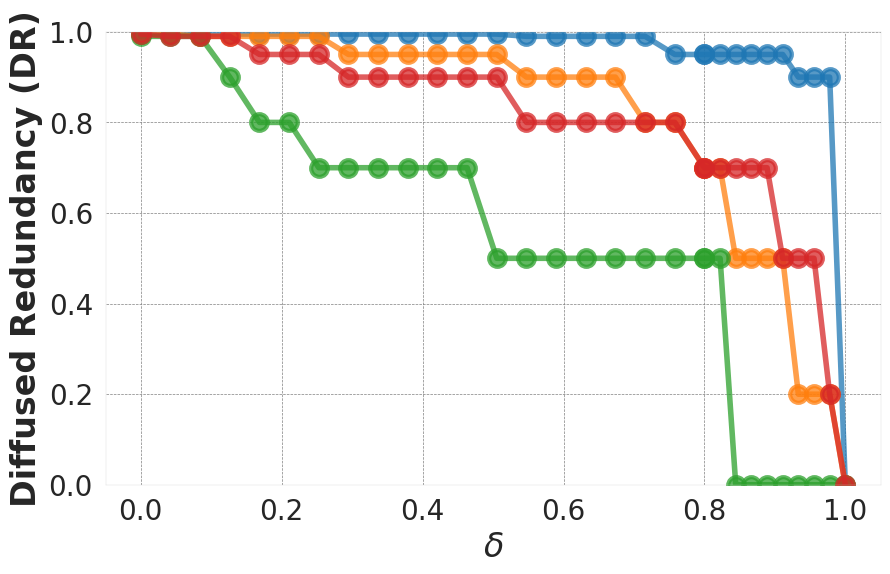

[True, True, True, True]


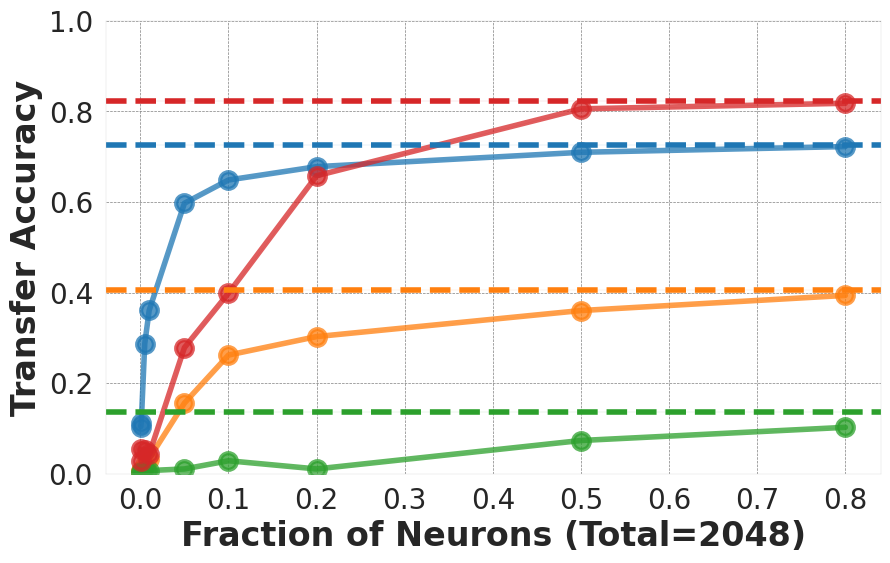

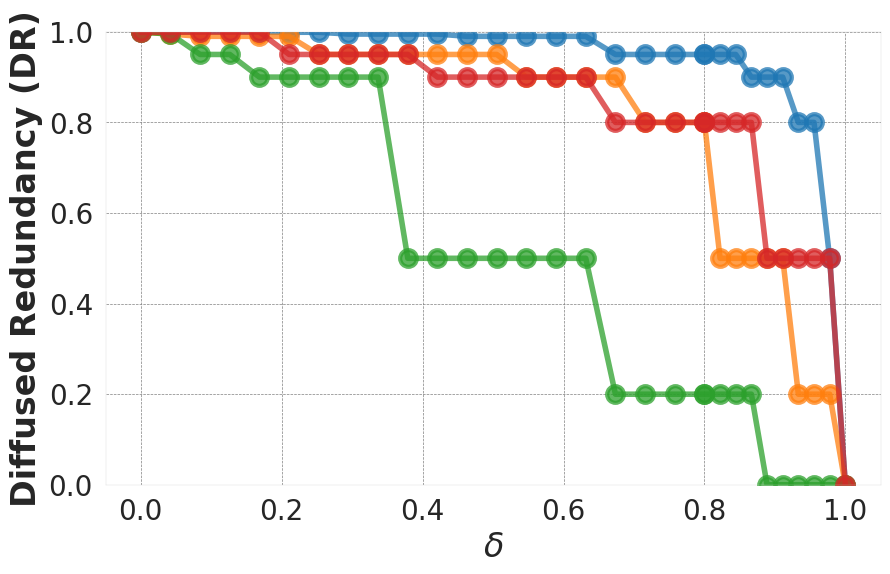

[True, True, True, True]


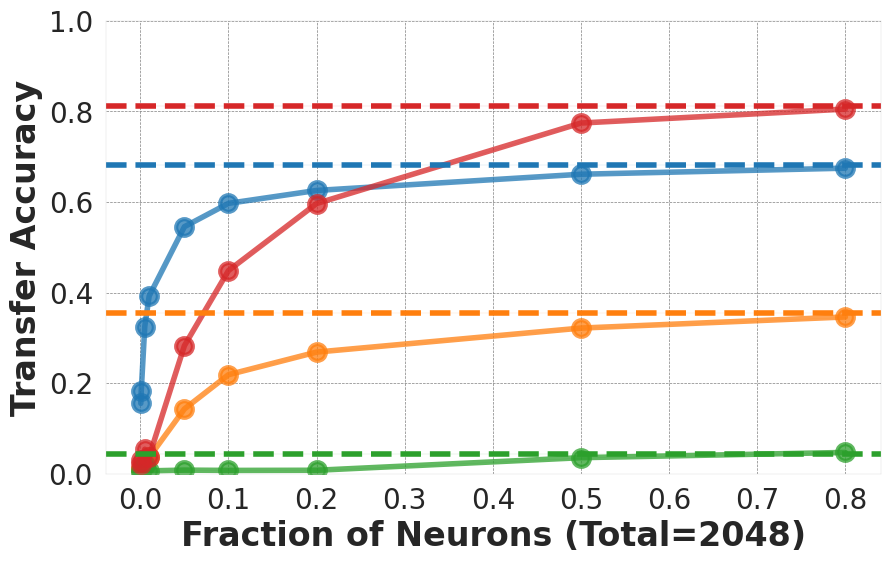

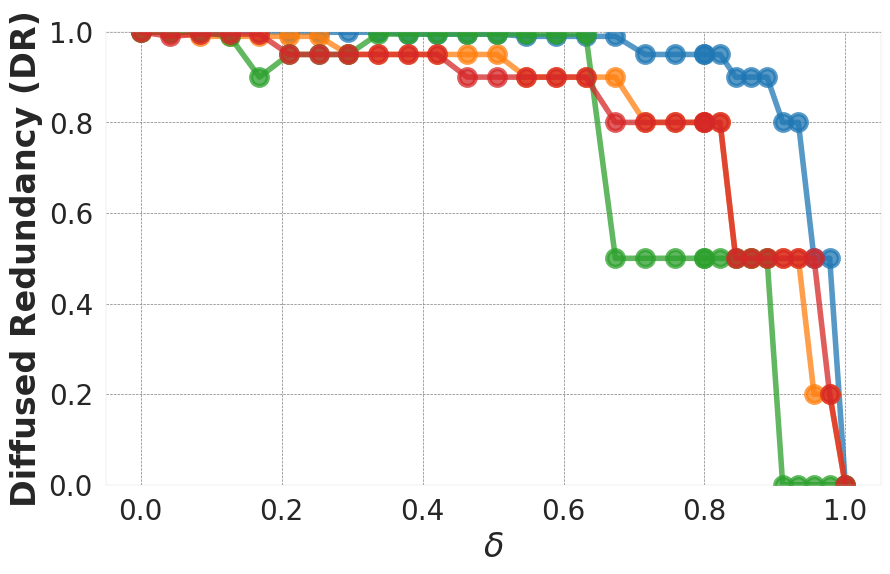

[True, True, True, True]


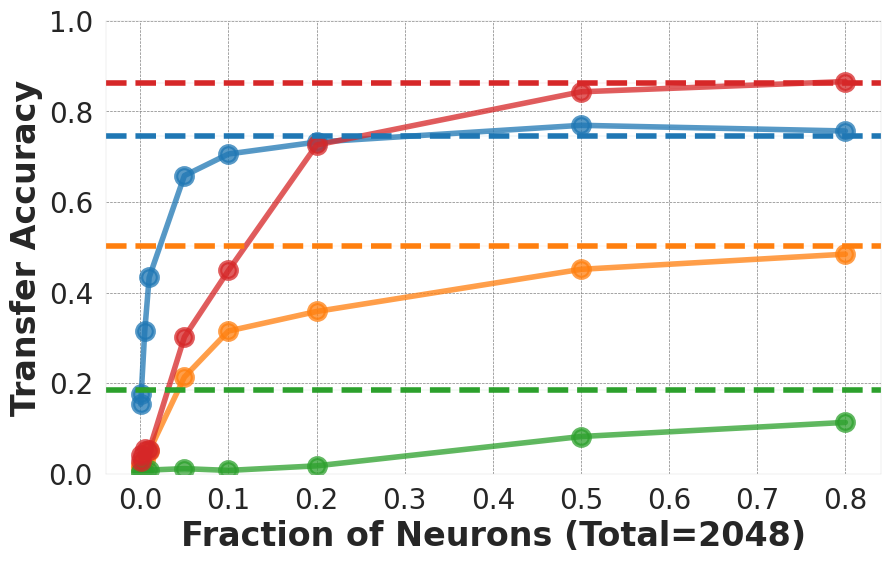

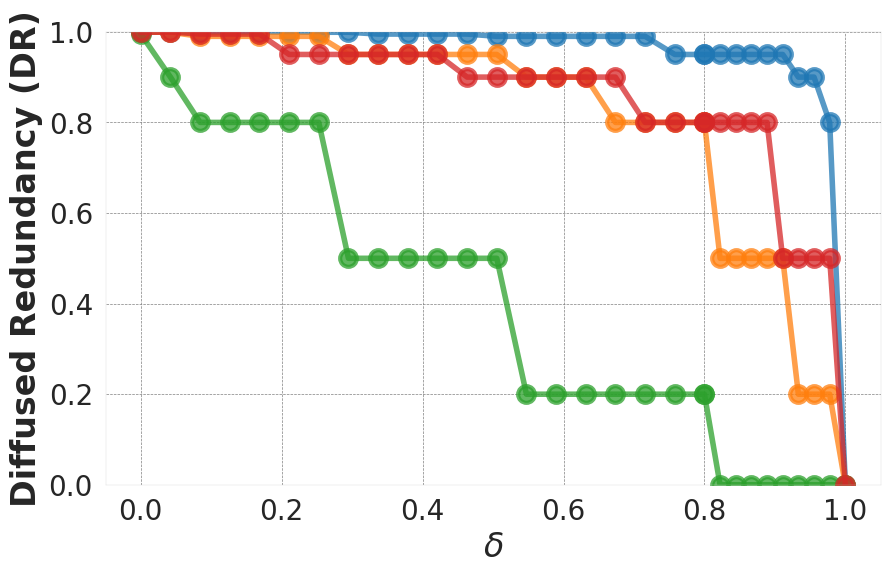

[True, True, True, True]


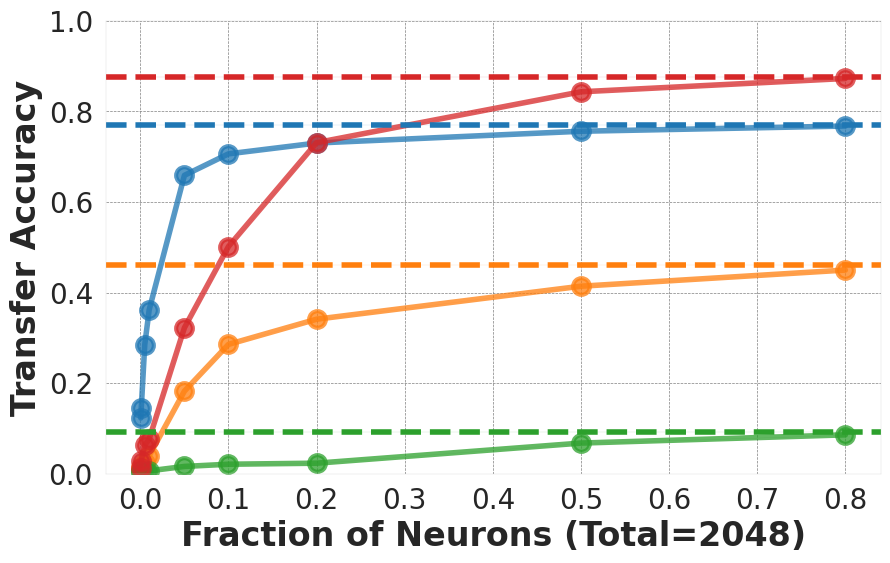

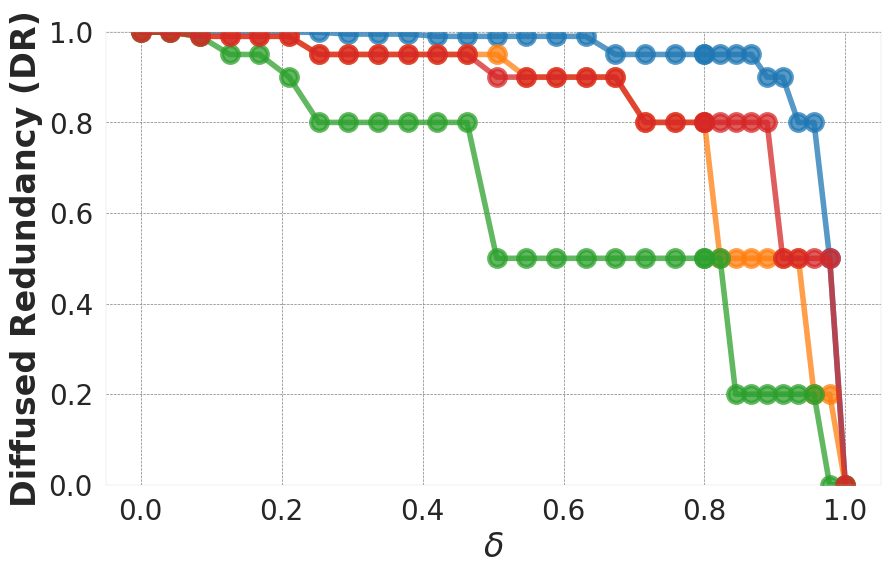

In [18]:
deltas = np.concatenate((np.linspace(0.,0.8,20), np.linspace(0.8,1.,10)))
for append in CHECKPOINT_PATHS['resnet50'].keys():
    all_x_vals, all_y_vals, all_full_accs = [], [], []
    all_dr_vals = []
    for ft_ds in FINETUNING_DATASETS:
        x, y = list(zip(*sorted(
            resnet50_allres[f'resnet50-{append}-{ft_ds}'].items(), key=lambda i:i[0])))
        all_full_accs.append(y[-1])
        all_x_vals.append(x[:-1])
        all_y_vals.append(y[:-1])
        all_dr_vals.append([estimate_dr(x, y, delta) for delta in deltas])
        
    all_y_means = [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals]
    print ([len(all_y_means[i]) == len(all_x_vals[i]) for i in range(len(all_x_vals))])
    plt_hp.line_plot(
        [[np.mean(_y) for _y in y_vals] for y_vals in all_y_vals], 
        'Fraction of Neurons (Total=2048)', 'Transfer Accuracy', '', 
        subfolder=SOURCE_DATASET, filename=f'{MODEL}_allds_bs_{BATCH_SIZE}_{append}_{FINETUNE_MODE}', 
        extension='png', x_vals=all_x_vals, legend_vals=FINETUNING_DATASETS, vertical_line=None, 
        horizontal_lines=[np.mean(full_acc) for full_acc in all_full_accs], 
        horizontal_lines_err=[np.std(full_acc) for full_acc in all_full_accs], 
        colors=plt_hp.COLORS[:len(FINETUNING_DATASETS)] * 2, 
        linestyles=['-']*len(FINETUNING_DATASETS) + [':']*len(FINETUNING_DATASETS), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, figsize=(10,6), 
        marker=[True] * len(FINETUNING_DATASETS) + [False] * len(FINETUNING_DATASETS), 
        results_subfolder_name='decorrelation_analysis', grid_spacing=None, 
        y_err=[[np.std(_y) for _y in y_vals] for y_vals in all_y_vals], legend_ncol=None)
    plt_hp.line_plot(
        all_dr_vals, 
        r'$\delta$', 'Diffused Redundancy (DR)', '', 
        subfolder=SOURCE_DATASET, filename=f'{MODEL}_allds_{append}_{FINETUNE_MODE}_diffused_redundancy', 
        extension='png', x_vals=[deltas] * len(all_dr_vals), 
        legend_vals=FINETUNING_DATASETS, vertical_line=None, 
        colors=plt_hp.COLORS[:len(FINETUNING_DATASETS)], 
        linestyles=['-']*len(FINETUNING_DATASETS), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, figsize=(10,6), 
        marker=[True] * len(FINETUNING_DATASETS) + [False] * len(FINETUNING_DATASETS), 
        results_subfolder_name='decorrelation_analysis', grid_spacing=None, 
        y_err=None, legend_ncol=None)